In [1]:
from pytket.circuit import Circuit, CircBox, QControlBox
from jax import numpy as jnp
from jax import random, jit, Array
import numpy as np
import phayes as bys
import matplotlib.pyplot as plt

In [2]:
# Gate Declerations
P = jnp.array([[1, 0], [0, jnp.exp(1.j * np.pi / 4)]])

def Rz(theta):
    return jnp.array([[np.exp(- 0.5j * theta), 0], [0, jnp.exp(0.5j * theta)]])

H = jnp.array([[1, 1], [1, -1]]) / jnp.sqrt(2)

In [3]:
# Target Matrix (trying to get its eigenphase) set to whatever
theta = np.pi / 2
U_Rz = jnp.array([[np.exp(- 0.5j * theta), 0], [0, jnp.exp(0.5j * theta)]])
U = jnp.kron(P, H @ U_Rz @ H)

In [4]:
#True Phase calculator
e_vs, e_vecs = jnp.linalg.eig(U)
orthoganal = 0 # Set to 0 if true
x_vec = e_vecs[:, orthoganal]
true_phase = np.arccos(e_vs[orthoganal].real)

In [5]:
# Mass Hadamard Generator
n_qubits_U = int(np.log2(U.shape[0]))

big_H = jnp.kron(H, jnp.eye(U.shape[0]))
in_statevector = jnp.kron(jnp.array([1, 0]), x_vec)

In [6]:
def build_bayes_circ(k: int, beta: float) -> jnp.ndarray:
    k = int(k)
    big_Rz = jnp.kron(Rz(beta), jnp.eye(U.shape[0]))
    U_k = jnp.linalg.matrix_power(U, k)
    controlled_U_k = jnp.block([[jnp.eye(U.shape[0]), jnp.zeros(U.shape)], [jnp.zeros(U.shape), U_k]])
    
    out_statevector = big_H @ controlled_U_k @ big_Rz @ big_H @ in_statevector
    meas = jnp.abs(out_statevector) ** 2
    meas_q1 = meas.reshape((2, ) * (n_qubits_U + 1)).sum(axis=tuple(range(1, n_qubits_U + 1)))
    return meas_q1


def gen_circs(k: int, beta: float, n_shots: int, random_key: Array) -> jnp.ndarray:
    bayes_result = build_bayes_circ(k, beta)
    return random.choice(random_key, a=jnp.arange(2), p=bayes_result, shape=(n_shots,))

In [9]:
# Estimate that Phase
def bayes_iterator(prior_state: jnp.ndarray, n_shots: int, random_key: Array) -> jnp.ndarray:
    k, beta = jit(bys.get_k_and_beta)(prior_state)
    shots = gen_circs(k, beta, n_shots, random_key)
    posterior_state = jit(bys.update)(prior_state, shots, k, beta)
    return beta, k, posterior_state

In [10]:
def bqpe(n: int, betas, ks, states):
    
    shots = 100
    random_keys = random.split(random.key(0), n_rounds)
    for i in range(n_rounds):
        beta, k, new_state = bayes_iterator(states[i], shots, random_keys[i])
        
        print(f"Experiment {i + 1} of {n_rounds}, k={k}, beta={beta:.2f}, coeffs used: {(new_state.fourier_coefficients != 0).sum() // 2}/{new_state.fourier_coefficients[0].size}")
    
        states.append(new_state)
        ks.append(k)
        betas.append(beta)

In [11]:
# MAIN
## Set number of iterations with n_rounds
n_rounds = 5

## Number of fourier coefficents. Warning this is mem heavy!
fourier_coes = 100 

states = [bys.init(fourier_coes)]
ks = []
betas = []

bqpe(n_rounds, betas, ks, states)

Experiment 1 of 5, k=1, beta=1.57, coeffs used: 95/100
Experiment 2 of 5, k=2, beta=1.57, coeffs used: 0/100
Experiment 3 of 5, k=16, beta=1.51, coeffs used: 0/100
Experiment 4 of 5, k=157, beta=0.00, coeffs used: 0/100
Experiment 5 of 5, k=71, beta=0.00, coeffs used: 0/100


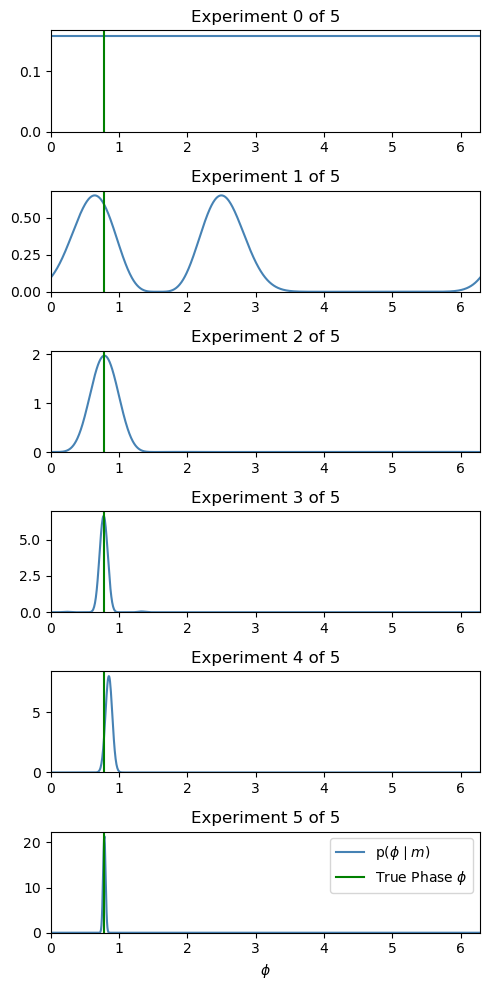

In [20]:
pdf_linsp = jnp.linspace(0, 2 * jnp.pi, 1000)

fig, axes = plt.subplots(n_rounds + 1, figsize=(5, 10))
for i in range(n_rounds + 1):
    axes[i].plot(pdf_linsp, bys.pdf(pdf_linsp, states[i]), c='steelblue', label=f'p($\phi \mid m)$')
    axes[i].axvline(true_phase, color='green', label=r'True Phase $\phi$')
    axes[i].set_title(f"Experiment {i} of {n_rounds}")
    axes[i].set_xlim(0, 2 * jnp.pi)
    axes[i].set_ylim(0, axes[i].get_ylim()[1])
axes[-1].set_xlabel(r'$\phi$')
axes[-1].legend()
fig.tight_layout()